In [1]:
%matplotlib inline

from Bio.Seq import Seq
from Bio import SeqIO
from Bio.Alphabet import IUPAC

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.ensemble import RandomForestClassifier

import shap

In [2]:
shap.__version__

'0.28.5'

### Sequence alignment files (.aln format)

Put the files names (relative paths) in a list.

We will iterate over this list to read the sequences into dataframes.

In [3]:
file_1 = '../DATA/!CLEAN/2019-01-30_ZIBRA2_YFV-RIO-Diferentes_CTs'

file_2 = '../DATA/!CLEAN/NHP_65_outbreak'

file_3 = '../DATA/!CLEAN/2018-01_Salvador'

file_4 = '../DATA/!CLEAN/2018-03-04_LACEN_Bahia'

file_5 = '../DATA/!CLEAN/FUNED_AGOSTO-2018'

file_6 = '../DATA/!CLEAN/RIO_DE_JANEIRO'

file_7 = '../DATA/!CLEAN/YFV_LACEN_BAHIA'

In [4]:
file_list = [file_1,
            file_2,
            file_3,
            file_4,
            file_5,
            file_6,
            file_7]
seq_list = []
metadata_list = []

In [5]:
for file in file_list:
    seq_file = file + '.aln'
    metadata_file = file + '.xlsx'
    
    seq_list.append(seq_file)
    metadata_list.append(metadata_file)

### Dataframes containing YFV sequences
A function to iterate over all file names and create a dataframe containing the **nucleotide sequences** for each one, putting them in a _dictionary_.

In [6]:
def create_seq_df(file):
    # Creates a dataframe based on a ".aln" file.
    
    # Gets the sequences IDs
    identifiers = [seq_record.id for seq_record in SeqIO.parse(file, "clustal")]
    
    # Gets the sequences nucleotides
    seq = np.array([list(str(seq_rec.seq)) for seq_rec in SeqIO.parse(file, "clustal")])
    
    # Creates columns names based on position, starting from 1, to make it consistent with the 
    # sequence analysis, which starts at base number 1.
    cols = list(range(1, seq.shape[1]+1))
    
    # Creates dataframe with data
    seq_df = pd.DataFrame(seq, index=identifiers, columns=cols)
    
    return seq_df

In [7]:
seq_dict = {}
for file in seq_list:
    print(file)
    df = create_seq_df(file)
    seq_dict[file] = df

../DATA/!CLEAN/2019-01-30_ZIBRA2_YFV-RIO-Diferentes_CTs.aln
../DATA/!CLEAN/NHP_65_outbreak.aln
../DATA/!CLEAN/2018-01_Salvador.aln
../DATA/!CLEAN/2018-03-04_LACEN_Bahia.aln
../DATA/!CLEAN/FUNED_AGOSTO-2018.aln
../DATA/!CLEAN/RIO_DE_JANEIRO.aln
../DATA/!CLEAN/YFV_LACEN_BAHIA.aln


### Metadata
The following code reads the excel spreadsheet containing the metadata related to the sequences and includes them in the dataframe.

One spreadsheet per group of sequences from ZIBRA database, all into a _dictionary_.

I only keep the information I'm going to use now, i.e., 'Host', 'Date' and 'Ct'.

I use regex to link the spreadsheet to the sequences.


In [8]:
def read_metadata(excel_file):
    metadata_df = pd.read_excel(excel_file, index_col='index')
    metadata_df = metadata_df[['Host', 'Date', 'Ct']]
    return metadata_df

In [9]:
metadata_dict = {}
for file in metadata_list:
    print(file)
    metadata_df = read_metadata(file)
    metadata_dict[file] = metadata_df

../DATA/!CLEAN/2019-01-30_ZIBRA2_YFV-RIO-Diferentes_CTs.xlsx
../DATA/!CLEAN/NHP_65_outbreak.xlsx
../DATA/!CLEAN/2018-01_Salvador.xlsx
../DATA/!CLEAN/2018-03-04_LACEN_Bahia.xlsx
../DATA/!CLEAN/FUNED_AGOSTO-2018.xlsx
../DATA/!CLEAN/RIO_DE_JANEIRO.xlsx
../DATA/!CLEAN/YFV_LACEN_BAHIA.xlsx


### Regex
Parse through metadata and sequences IDs, linking information and adding it to the seqs dataframes.

In [10]:
import re

In [11]:
index_bookeeping = {} # to avoid matching multiple sequences for the same ID.
for file in file_list: # compare seq_df to metadata_df in a pairwise manner.
    seq_file = file + '.aln'
    metadata_file = file + '.xlsx'
    
    seq_df = seq_dict[seq_file]
    metadata_df = metadata_dict[metadata_file]
    
    # Prepare seq_df to receive the metadata info.
    seq_df.insert(0, 'ID', 'id')
    seq_df.insert(1, 'Host', 'host')
    seq_df.insert(2, 'Ct', 'ct')
    seq_df.insert(3, 'Date', 'date')
    
    # For each ID in metadata (here in its index).
    # In the excel files, there is a column called "index".
    # This column was used as the "metadata dataframe" index.
    # So I iterate over these indexes and look for them (try to match them using regex) in the fasta file ID.
    for index_a, sample_a in metadata_df.iterrows():
        # I have pre-edited the fasta files ID fields to put the index values between vertical bars "|".
        # This was to make it easier to create a pattern and use regex.
        pattern = '\|' + str(index_a) + '\|'
        regex = re.compile(pattern)
        # For each fasta ID (index_b) in the file...
        for index_b, sample_b in seq_df.iterrows():
            # If the metadata index is in this fasta ID...
            if regex.search(index_b):
                # if this sequence still has no metadata values associated...
                if seq_df.loc[index_b,'ID'] == 'id':
                    # fill in metadata values to seq_df
                    seq_df.loc[index_b,'ID'] = index_a
                    seq_df.loc[index_b,'Host'] = metadata_df.loc[index_a, 'Host']
                    seq_df.loc[index_b,'Date'] = metadata_df.loc[index_a, 'Date']
                    seq_df.loc[index_b,'Ct'] = metadata_df.loc[index_a, 'Ct']
                    index_bookeeping[index_a] = 1
                # else, if this sequence already has metadata values associated
                # (this happens because identical sequences are grouped together, and their fasta IDs 
                # keep all the information of all these sequences)
                # and if this is the first time this specific index_a is matched...
                elif index_a not in index_bookeeping:
                    # Copy the sequence, but with new metadata, and append it to seq_df
                    sample_copy = pd.Series(sample_b)
                    index_copy = str(index_a+'_')+str(index_b)
                    sample_copy.name = index_copy
                    seq_df.append(sample_copy)
                    seq_df.loc[index_copy,'ID'] = index_a
                    seq_df.loc[index_copy,'Host'] = metadata_df.loc[index_a, 'Host']
                    seq_df.loc[index_copy,'Date'] = metadata_df.loc[index_a, 'Date']
                    seq_df.loc[index_copy,'Ct'] = metadata_df.loc[index_a, 'Ct']
                    index_bookeeping[index_a] = 1
    

### Merge all dataframes into one 

In [12]:
dfs = list(seq_dict.values())

In [13]:
len(dfs)

7

In [14]:
for df in dfs:
    print(df.shape)

(32, 10084)
(26, 10084)
(16, 10084)
(1, 10084)
(12, 10084)
(2, 10084)
(9, 10084)


In [15]:
seq_df = pd.concat(dfs)

In [16]:
seq_df

,ID,Host,Ct,Date,1,2,3,4,5,6,...,10071,10072,10073,10074,10075,10076,10077,10078,10079,10080
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY01|_CARIACICA_Alouatta_sp_08-03-2017,RJY01,Alouatta,11.22,2017-03-08 00:00:00,A,A,A,A,C,C,...,C,A,G,A,G,C,C,A,C,T
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY03|_SANTA_MARIA_MADALENA_Alouatta_sp_02-05-2017,RJY03,Alouatta,11.56,2017-05-02 00:00:00,A,A,A,A,C,C,...,C,A,G,A,G,C,C,A,C,T
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY04|_SUMIDOURO_Alouatta_sp_22-12-2017,RJY04,Alouatta,11.45,2017-12-22 00:00:00,A,A,A,A,C,C,...,C,A,G,A,G,C,C,A,C,T
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY05|_ANGRA_DOS_REIS_Alouatta_sp_18-01-2018,RJY05,Alouatta,11.04,2018-01-18 00:00:00,A,A,A,A,C,C,...,C,A,G,A,G,C,C,A,C,T
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY09|_ITAMARANDIBA_Alouatta_sp_13-02-2017,RJY09,Alouatta,22.3,2017-02-13 00:00:00,A,A,A,A,C,C,...,C,A,G,A,G,C,C,A,C,T
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY10|_ANGRA_DOS_REIS_Alouatta_sp_19-02-2018,RJY10,Alouatta,14.335,2018-02-19 00:00:00,A,A,A,A,C,C,...,C,A,G,A,G,C,C,A,C,T
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY12|_SANTA_TEREZA_Alouatta_sp_15-02-2017,RJY12,Alouatta,16.425,2017-02-15 00:00:00,A,A,A,A,C,C,...,C,A,G,A,G,C,C,A,C,T
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY13|_CARMO_Alouatta_sp_17-04-2017,RJY13,Alouatta,14.43,2017-04-17 00:00:00,A,A,A,A,C,C,...,C,A,G,A,G,C,C,A,C,T
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY14|_GUAPIMIRIM_Callithrix_sp_06-06-2017,RJY14,Callithrix,20.715,2017-06-06 00:00:00,A,A,A,A,C,C,...,C,A,G,A,G,C,C,A,C,T
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY15|_CARIACICA_Callithrix_sp_09-03-2017,RJY15,Callithrix,13.395,2017-03-09 00:00:00,A,A,A,A,C,C,...,C,A,G,A,G,C,C,A,C,T


### Data Cleaning

In [17]:


seq_df = seq_df[seq_df['Ct'].notnull()]

seq_df = seq_df[seq_df['Ct'] != 'ct']

seq_df['Ct'] = pd.to_numeric(seq_df['Ct'])

seq_df['Ct'] = seq_df['Ct'].astype(np.float16)

seq_df['Date'] = pd.to_datetime(seq_df['Date'])

seq_df.replace('Allouata', 'Alouatta', inplace=True)
seq_df.replace('cebidae', 'Cebidae', inplace=True)
seq_df.replace('NHP (unk)', 'unk', inplace=True)
seq_df.replace('Sem informação','unk', inplace=True)

print(seq_df['Host'].unique())

['Alouatta' 'Callithrix' 'Callicebus' 'Cebus' 'unk' 'Cebidae']


In [18]:
seq_df.head()

,ID,Host,Ct,Date,1,2,3,4,5,6,...,10071,10072,10073,10074,10075,10076,10077,10078,10079,10080
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY01|_CARIACICA_Alouatta_sp_08-03-2017,RJY01,Alouatta,11.218750,2017-03-08,A,A,A,A,C,C,...,C,A,G,A,G,C,C,A,C,T
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY03|_SANTA_MARIA_MADALENA_Alouatta_sp_02-05-2017,RJY03,Alouatta,11.562500,2017-05-02,A,A,A,A,C,C,...,C,A,G,A,G,C,C,A,C,T
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY04|_SUMIDOURO_Alouatta_sp_22-12-2017,RJY04,Alouatta,11.453125,2017-12-22,A,A,A,A,C,C,...,C,A,G,A,G,C,C,A,C,T
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY05|_ANGRA_DOS_REIS_Alouatta_sp_18-01-2018,RJY05,Alouatta,11.039062,2018-01-18,A,A,A,A,C,C,...,C,A,G,A,G,C,C,A,C,T
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY09|_ITAMARANDIBA_Alouatta_sp_13-02-2017,RJY09,Alouatta,22.296875,2017-02-13,A,A,A,A,C,C,...,C,A,G,A,G,C,C,A,C,T


In [19]:
seq_df.insert(4, 'Season', 'season')

In [20]:
mask = seq_df['Date'] < pd.datetime(2017,8,1)
seq_df.loc[mask, 'Season'] = '2016/2017'

mask = seq_df['Date'] >= pd.datetime(2017,8,1)
seq_df.loc[mask, 'Season'] = '2017/2018'

seq_df

,ID,Host,Ct,Date,Season,1,2,3,4,5,...,10071,10072,10073,10074,10075,10076,10077,10078,10079,10080
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY01|_CARIACICA_Alouatta_sp_08-03-2017,RJY01,Alouatta,11.218750,2017-03-08,2016/2017,A,A,A,A,C,...,C,A,G,A,G,C,C,A,C,T
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY03|_SANTA_MARIA_MADALENA_Alouatta_sp_02-05-2017,RJY03,Alouatta,11.562500,2017-05-02,2016/2017,A,A,A,A,C,...,C,A,G,A,G,C,C,A,C,T
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY04|_SUMIDOURO_Alouatta_sp_22-12-2017,RJY04,Alouatta,11.453125,2017-12-22,2017/2018,A,A,A,A,C,...,C,A,G,A,G,C,C,A,C,T
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY05|_ANGRA_DOS_REIS_Alouatta_sp_18-01-2018,RJY05,Alouatta,11.039062,2018-01-18,2017/2018,A,A,A,A,C,...,C,A,G,A,G,C,C,A,C,T
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY09|_ITAMARANDIBA_Alouatta_sp_13-02-2017,RJY09,Alouatta,22.296875,2017-02-13,2016/2017,A,A,A,A,C,...,C,A,G,A,G,C,C,A,C,T
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY10|_ANGRA_DOS_REIS_Alouatta_sp_19-02-2018,RJY10,Alouatta,14.335938,2018-02-19,2017/2018,A,A,A,A,C,...,C,A,G,A,G,C,C,A,C,T
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY12|_SANTA_TEREZA_Alouatta_sp_15-02-2017,RJY12,Alouatta,16.421875,2017-02-15,2016/2017,A,A,A,A,C,...,C,A,G,A,G,C,C,A,C,T
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY13|_CARMO_Alouatta_sp_17-04-2017,RJY13,Alouatta,14.429688,2017-04-17,2016/2017,A,A,A,A,C,...,C,A,G,A,G,C,C,A,C,T
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY14|_GUAPIMIRIM_Callithrix_sp_06-06-2017,RJY14,Callithrix,20.718750,2017-06-06,2016/2017,A,A,A,A,C,...,C,A,G,A,G,C,C,A,C,T
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY15|_CARIACICA_Callithrix_sp_09-03-2017,RJY15,Callithrix,13.398438,2017-03-09,2016/2017,A,A,A,A,C,...,C,A,G,A,G,C,C,A,C,T


In [21]:
import seaborn as sns
sns.set(style="whitegrid")

In [22]:
callithrix_df = seq_df[seq_df['Host'] == 'Callithrix']

alouatta_df = seq_df[seq_df['Host'] == 'Alouatta']


In [23]:
def plot_figures(filename, df):
    fig, ax = plt.subplots()

    x = df['Date'].values
    y = df['Ct'].values

    ax = plt.scatter(x, y);
    
    fig.savefig('Scatter_' + filename, format='png', dpi=300, transparent=False)
    
    fig, ax = plt.subplots()
    data_17 = df[df['Date'] <= pd.datetime(2017,8,1)]
    data_18 = df[df['Date'] > pd.datetime(2017,8,1)]
    ax = plt.boxplot([data_17['Ct'], data_18['Ct']], labels=['2016/2017', '2017/2018']);
    
    fig.savefig('BoxPlot_' + filename, format='png', dpi=300, transparent=False)
    
    fig, ax = plt.subplots()
    ax = sns.violinplot(x="Season", y="Ct", data=df)
    
    fig.savefig('ViolinPlot_' + filename, format='png', dpi=300, transparent=False)
    

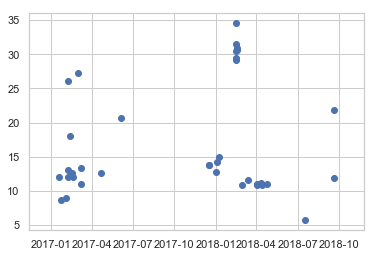

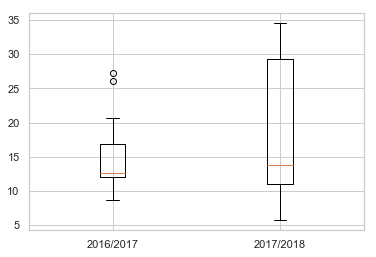

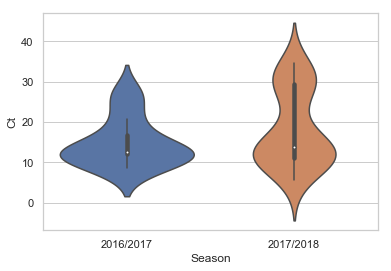

In [25]:
plot_figures('Callithrix_Ct.png', callithrix_df)

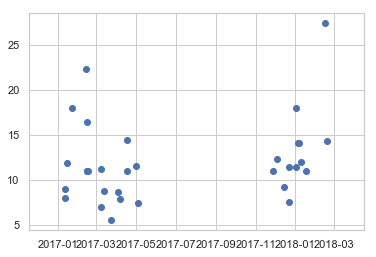

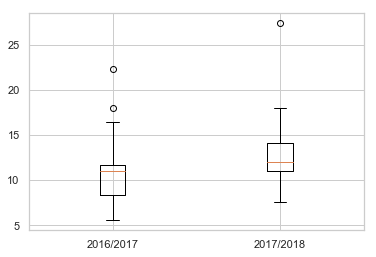

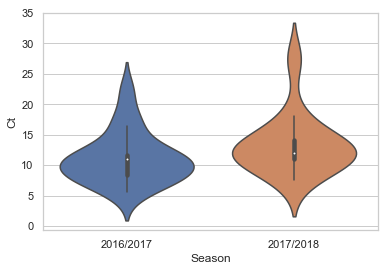

In [26]:
plot_figures('Alouatta_Ct.png', alouatta_df)

### One hot encoding

In [29]:
nucleotides_df = seq_df.iloc[:, 5:]
nucleotides_df.replace('N', np.nan, inplace=True)
nucleotides_df.replace('-', np.nan, inplace=True)
nucleotides_df.head()

,1,2,3,4,5,6,7,8,9,10,...,10071,10072,10073,10074,10075,10076,10077,10078,10079,10080
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY01|_CARIACICA_Alouatta_sp_08-03-2017,A,A,A,A,C,C,C,T,G,G,...,C,A,G,A,G,C,C,A,C,T
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY03|_SANTA_MARIA_MADALENA_Alouatta_sp_02-05-2017,A,A,A,A,C,C,C,T,G,G,...,C,A,G,A,G,C,C,A,C,T
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY04|_SUMIDOURO_Alouatta_sp_22-12-2017,A,A,A,A,C,C,C,NaN,NaN,G,...,C,A,G,A,G,C,C,A,C,T
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY05|_ANGRA_DOS_REIS_Alouatta_sp_18-01-2018,A,A,A,A,C,C,C,T,G,G,...,C,A,G,A,G,C,C,A,C,T
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY09|_ITAMARANDIBA_Alouatta_sp_13-02-2017,A,A,A,A,C,C,C,T,G,G,...,C,A,G,A,G,C,C,A,C,T


In [30]:
nucleotides_ohe_df = pd.get_dummies(nucleotides_df)
nucleotides_ohe_df.head()

,1_A,2_A,3_A,4_A,5_C,6_C,7_C,8_T,9_G,10_G,...,10072_A,10073_G,10074_A,10075_G,10076_C,10077_C,10078_A,10079_C,10080_C,10080_T
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY01|_CARIACICA_Alouatta_sp_08-03-2017,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,1
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY03|_SANTA_MARIA_MADALENA_Alouatta_sp_02-05-2017,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,1
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY04|_SUMIDOURO_Alouatta_sp_22-12-2017,1,1,1,1,1,1,1,0,0,1,...,1,1,1,1,1,1,1,1,0,1
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY05|_ANGRA_DOS_REIS_Alouatta_sp_18-01-2018,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,1
2019-01-30_ZIBRA2_YFV-RIO-Diferentes_Cts|RJY09|_ITAMARANDIBA_Alouatta_sp_13-02-2017,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,1


In [ ]:
seq_ohe_df = nucleotides_ohe_df


In [ ]:
seq_ohe_df.insert(0, 'ID', seq_df['ID'])
seq_ohe_df.insert(1, 'Host', seq_df['Host'])
seq_ohe_df.insert(2, 'Ct', seq_df['Ct'])
seq_ohe_df.insert(3, 'Date', seq_df['Date'])

In [ ]:
seq_ohe_df

In [ ]:
seq_ohe_df['Host'].unique()

### Save to .csv

In [ ]:
seq_df.to_csv('../DATA/!CLEAN/dataframe_YFV_seqs_metadata.csv', index=True, header=True, decimal=',', sep=' ', float_format='%.2f')

In [ ]:
seq_df.to_pickle('../DATA/!CLEAN/dataframe_YFV_seqs_metadata.pkl')

In [ ]:
nucleotides_ohe_df.to_pickle('../DATA/!CLEAN/nucleotides_ohe_df.pkl')